<a href="https://colab.research.google.com/github/gautham-umasankar/Quantum_COVID/blob/master/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Training



In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
from shutil import copyfile, copyfileobj
import gzip
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
from PIL import Image
import os
import matplotlib.image as mpimg
from scipy.ndimage import zoom


print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
GPU is available


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
copyfile("/content/drive/My Drive/Colab Notebooks/covid19-ct-scans.zip","/content/covid19-ct-scans.zip")
with ZipFile('/content/covid19-ct-scans.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('/content/covid19-ct-scans')

In [ ]:
# Read and examine metadata
raw_data = pd.read_csv('/content/covid19-ct-scans/metadata.csv')
raw_data = raw_data.replace('../input/covid19-ct-scans/','/content/covid19-ct-scans/',regex=True)
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
5,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
3,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
9,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...
10,/content/covid19-ct-scans/ct_scans/radiopaedia...,/content/covid19-ct-scans/lung_mask/radiopaedi...,/content/covid19-ct-scans/infection_mask/radio...,/content/covid19-ct-scans/lung_and_infection_m...
0,/content/covid19-ct-scans/ct_scans/coronacases...,/content/covid19-ct-scans/lung_mask/coronacase...,/content/covid19-ct-scans/infection_mask/coron...,/content/covid19-ct-scans/lung_and_infection_m...


In [ ]:
Height = 224
Width = 224

def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

@tf.function
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (Height, Width))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (Height, Width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.image.grayscale_to_rgb(input_image)
    input_image = tf.image.per_image_standardization(input_image)
    return input_image, input_mask

In [ ]:
num_of_files = len(raw_data)
train_test_split = 0.3
for idx in range(num_of_files):
    raw_image = read_nii(raw_data.loc[idx,'ct_scan'])
    raw_mask  = read_nii(raw_data.loc[idx,'lung_and_infection_mask'])
    slices = raw_image.shape[2]
    raw_image = raw_image[:,:,round(slices*0.2):round(slices*0.8)]
    raw_mask = raw_mask[:,:,round(slices*0.2):round(slices*0.8)]
    raw_image = np.reshape(np.rollaxis(raw_image, 2),(raw_image.shape[2],raw_image.shape[0],raw_image.shape[1],1))
    raw_mask = np.reshape(np.rollaxis(raw_mask, 2),(raw_mask.shape[2],raw_mask.shape[0],raw_mask.shape[1],1))
    print(raw_image.shape,raw_mask.shape)
    raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
    raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)

    temp = tf.data.Dataset.from_tensor_slices({'image':raw_image,'segmentation_mask':raw_mask})

    if idx == 0:
        dataset = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    else:
        dataset = dataset.concatenate(temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE))

print(dataset.element_spec)

TOTAL_LENGTH = tf.data.experimental.cardinality(dataset).numpy()

dataset = dataset.shuffle(TOTAL_LENGTH)
test_dataset = dataset.take(round(train_test_split*TOTAL_LENGTH))
train_dataset = dataset.skip(round(train_test_split*TOTAL_LENGTH))

TEST_LENGTH = round(train_test_split*TOTAL_LENGTH)
TRAIN_LENGTH = TOTAL_LENGTH - TEST_LENGTH
BATCH_SIZE = 16
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_dataset_batched = train_dataset.cache().batch(BATCH_SIZE).repeat()
train_dataset_batched = train_dataset_batched.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset_batched = test_dataset.batch(BATCH_SIZE)
print(TRAIN_LENGTH, TEST_LENGTH)

(181, 512, 512, 1) (181, 512, 512, 1)
(120, 512, 512, 1) (120, 512, 512, 1)
(120, 512, 512, 1) (120, 512, 512, 1)
(162, 512, 512, 1) (162, 512, 512, 1)
(174, 512, 512, 1) (174, 512, 512, 1)
(127, 512, 512, 1) (127, 512, 512, 1)
(149, 512, 512, 1) (149, 512, 512, 1)
(181, 512, 512, 1) (181, 512, 512, 1)
(154, 512, 512, 1) (154, 512, 512, 1)
(181, 512, 512, 1) (181, 512, 512, 1)
(23, 630, 630, 1) (23, 630, 630, 1)
(250, 630, 630, 1) (250, 630, 630, 1)
(66, 401, 630, 1) (66, 401, 630, 1)
(40, 630, 630, 1) (40, 630, 630, 1)
(26, 630, 630, 1) (26, 630, 630, 1)
(26, 630, 630, 1) (26, 630, 630, 1)
(27, 630, 630, 1) (27, 630, 630, 1)
(55, 630, 630, 1) (55, 630, 630, 1)
(23, 630, 630, 1) (23, 630, 630, 1)
(27, 630, 630, 1) (27, 630, 630, 1)
(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(224, 224, 1), dtype=tf.float64, name=None))
1478.0 634.0


In [ ]:
print(TOTAL_LENGTH)

2112


{0.0: 41118, 1.0: 8875, 2.0: 183}


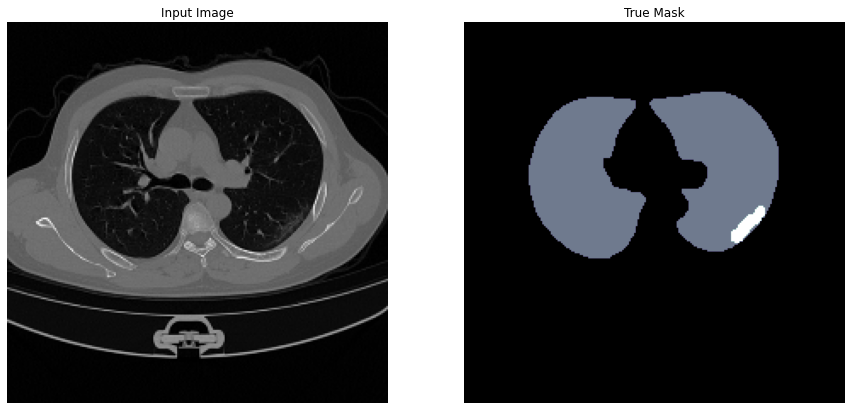

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='bone')
        plt.axis('off')
    plt.show()

for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
    unique, counts = np.unique(sample_mask, return_counts=True)
    print(dict(zip(unique, counts)))
    display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3 #None, Lung, Infection
base_model = tf.keras.applications.MobileNetV2(input_shape=[Height, Width, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',   
    'block_6_expand_relu',   
    'block_13_expand_relu',  
    'block_16_project',      
]
layers = [base_model.get_layer(name).output for name in layer_names]
# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
up_stack = [
    pix2pix.upsample(512, 3), 
    pix2pix.upsample(256, 3), 
    pix2pix.upsample(128, 3), 
    pix2pix.upsample(64, 3),
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[Height, Width, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

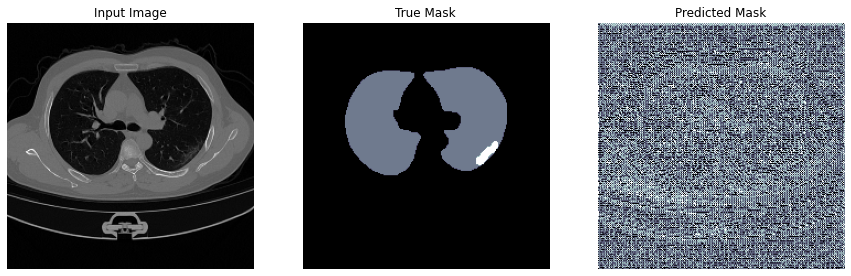

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

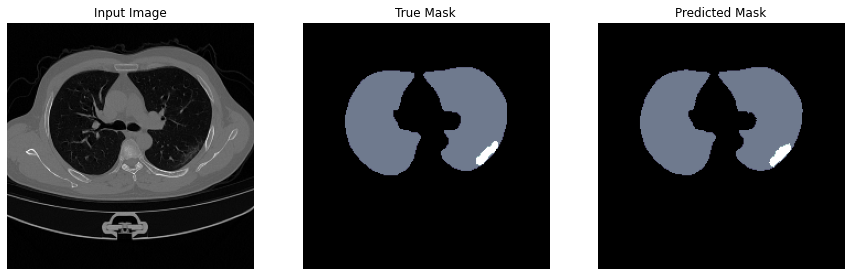


Sample Prediction after epoch 20

92/92 [==============================] - 12s 135ms/step - loss: 0.0123 - accuracy: 0.9951 - val_loss: 0.0150 - val_accuracy: 0.9943


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = TEST_LENGTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset_batched, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset_batched,
                          callbacks=[DisplayCallback()])

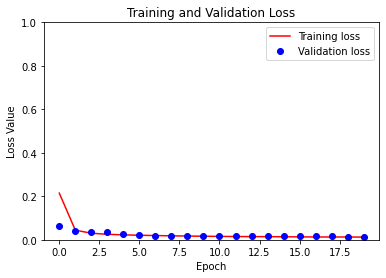

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

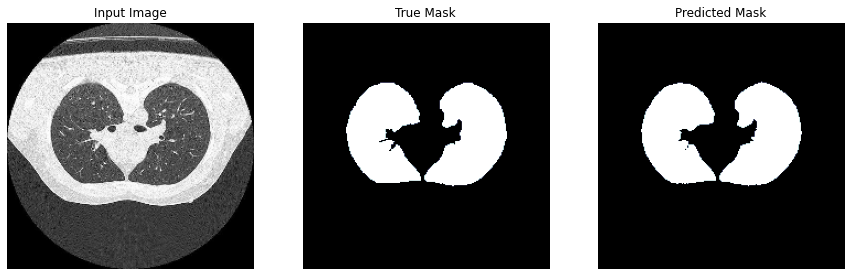

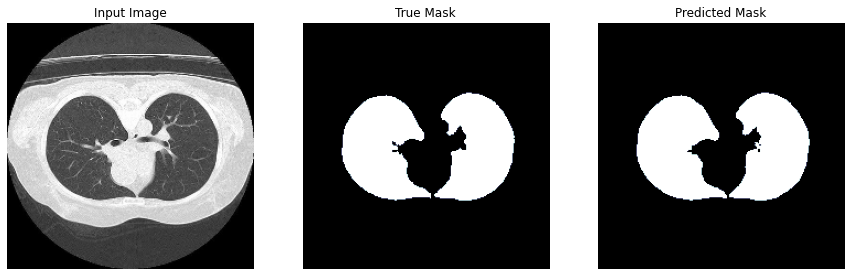

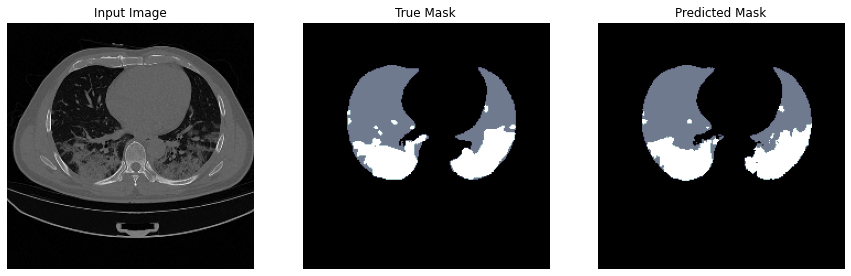

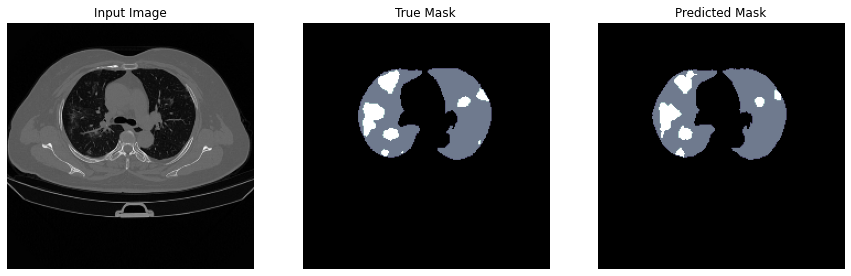

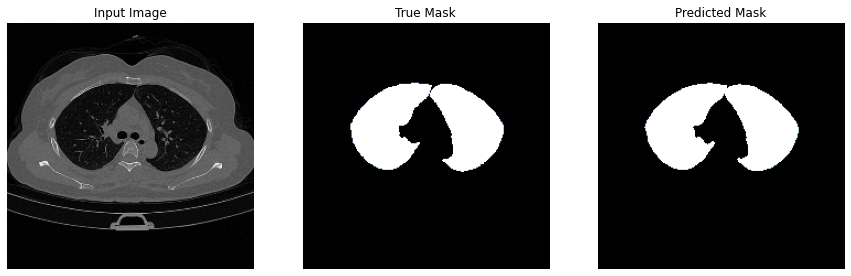

In [ ]:
show_predictions(test_dataset_batched, num=5)

# Understanding the flow of creating a test datapoint (Other data)

##Function for reading a bunch of jpeg files from a 3D array

In [ ]:
def scan_read(path):
  img_list = os.listdir(path)
  img_list.sort()
  n_img = len(img_list)
  img = np.zeros((512,512,n_img))
  for i in range(n_img):
    imag = Image.open(path + img_list[i]).convert('L')
    imag = np.array(imag)
    img[:,:,i] = imag
  print("Shape of the image: ",img.shape)
  return img


##Loading and resizing one CT Scan

In [ ]:
idx = 0
path = '/content/drive/My Drive/Colab Notebooks/COVID19-1/NCP/1001/2559/'
raw_image = scan_read(path)
raw_mask  = np.zeros(raw_image.shape)
print(raw_image.shape,raw_mask.shape)
slices = raw_image.shape[2]
raw_image = raw_image[:,:,round(slices*0.2):round(slices*0.8)]
raw_mask = raw_mask[:,:,round(slices*0.2):round(slices*0.8)]
raw_image = np.reshape(np.rollaxis(raw_image, 2),(raw_image.shape[2],raw_image.shape[0],raw_image.shape[1],1))
raw_mask = np.reshape(np.rollaxis(raw_mask, 2),(raw_mask.shape[2],raw_mask.shape[0],raw_mask.shape[1],1))
print(raw_image.shape,raw_mask.shape)
raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)


Shape of the image:  (512, 512, 141)
(512, 512, 141) (512, 512, 141)
(85, 512, 512, 1) (85, 512, 512, 1)


##Converting it into a dataset variable

In [ ]:
temp = tf.data.Dataset.from_tensor_slices({'image':raw_image,'segmentation_mask':raw_mask})
print("idx = ",idx)
if idx == 0:
    dataset_trial = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
else:
    dataset_trial = dataset_trial.concatenate(temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE))
print(len(dataset_trial))

idx =  0
85


##Making and showing a Prediction

The length of the take data is :  85
The length of the data is:  85
The number of images:  85
85 (224, 224)
255 0


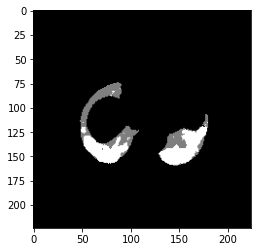

In [ ]:
predict_data = dataset_trial.take(1000)
print("The length of the take data is : ",len(predict_data))
predict_data = predict_data.batch(1)
print("The length of the data is: ",len(predict_data))
#show_predictions(predict_data, num=1)
a = []
img_count = 0
for image, mask in predict_data.take(1000):
  img_count = img_count + 1
  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)
  a.append(np.array(tf.keras.preprocessing.image.array_to_img(pred_mask)))
  
print("The number of images: ",img_count)  
print(len(a),a[0].shape)
print(a[0].max(),a[0].min())
# # for i in a[0]:
# #   for j in i[::10]:
# #     print(j)
# plt.imshow(a[0],cmap='gray')
# plt.imshow(a[10],cmap = 'gray')
plt.imshow(a[20],cmap = 'gray')
plt.show()


# def create_mask(pred_mask):
#     pred_mask = tf.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[..., tf.newaxis]
#     return pred_mask[0]

# def show_predictions(dataset=None, num=1):
#     if dataset:
#         for image, mask in dataset.take(num):
#             pred_mask = model.predict(image)
#             display([image[0], mask[0], create_mask(pred_mask)])
#     else:
#         display([sample_image, sample_mask,
#         create_mask(model.predict(sample_image[tf.newaxis, ...]))])


# Loading multiple NCP scans and Normal scans




## Loading the data

###NCP scans

In [ ]:
patient_list = os.listdir(path_normal)
patient_list_existing = os.listdir(path_normal_save)
print(len(patient_list),len(patient_list_existing))
for i in patient_list_existing:
  for j in patient_list:
    if i.split('_')[0] == j:
      patient_list.remove(j)

print(len(patient_list),len(patient_list_existing))

145 50
95 50


In [ ]:
def mask_generator(path,path_save,n):
  '''generates the masks of 'n' patients in a given folder and stores them'''
  patient_list = os.listdir(path)
  patient_list_temp = []
  patient_list_existing = os.listdir(path_save)
  for patient in patient_list:
    patient_list_temp.append(int(patient))
  patient_list_temp.sort()
  del patient_list
  patient_list = []
  for patient in patient_list_temp:
    patient_list.append(str(patient))
  for i in patient_list_existing:
    for j in patient_list:
      if i.split('_')[0] == j:
        patient_list.remove(j)
  n_patient = len(patient_list)
  print("The number of new patients is: ",n_patient)
  del patient_list_temp
  del patient_list_existing

  for i in np.arange(n):
    path_i = path + patient_list[i] + '/'
    scans = os.listdir(path_i)
    scans.sort()
    scan_i = path_i + scans[0] + '/'
    a = scan_read(scan_i)
    raw_image = zoom(a, (1.0, 1.0, (150.0/a.shape[2])))
    slices = raw_image.shape[2]
    raw_image = raw_image[:,:,round(slices*0.2):round(slices*0.8)]
    raw_image = np.reshape(np.rollaxis(raw_image, 2),(raw_image.shape[2],raw_image.shape[0],raw_image.shape[1],1))
    print("Shape of the image after resize: ",raw_image.shape)
    print("Added the scan of patient {}, scan {}".format(patient_list[i],scans[0]))
    raw_mask  = np.zeros(raw_image.shape)
    raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
    raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)
    temp = tf.data.Dataset.from_tensor_slices({'image':raw_image,'segmentation_mask':raw_mask})
    dataset = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    predict = dataset.take(1000)
    predict = predict.batch(1)
    a = np.zeros((224,224,len(predict.take(1000))))
    count = 0
    for image, mask in predict.take(1000):
      pred_mask = model.predict(image)
      pred_mask = create_mask(pred_mask)
      a[:,:,count] = np.array(tf.keras.preprocessing.image.array_to_img(pred_mask))
      count = count + 1
    print("The shape of the predicted mask is: ",a.shape)
    np.save(path_save + '/{}_{}.npy'.format(patient_list[i],scans[0]),a)
    #masks_ncp.append(a)
    del a
    del dataset
    del predict
    del temp
    del raw_image
    del raw_mask
    print("Patient number : ",i)
  del patient_list
    #ncp_scan_list.append(raw_image)

# n_ncp = 50
# n_normal = 50
# n_cp = 50
# path_ncp = '/content/drive/My Drive/Colab Notebooks/COVID19-1/NCP/'
# path_cp = '/content/drive/My Drive/Colab Notebooks/CP/'
# path_normal = '/content/drive/My Drive/Colab Notebooks/Ordered/'
# path_ncp_save = '/content/drive/My Drive/Colab Notebooks/Masks_final/NCP'
# path_cp_save = '/content/drive/My Drive/Colab Notebooks/Masks_final/CP'
# path_normal_save = '/content/drive/My Drive/Colab Notebooks/Masks_final/Normal'

# mask_generator(path_ncp,path_ncp_save,n_ncp)
#mask_generator(path_cp,path_cp_save,n_cp)
#mask_generator(path_normal,path_normal_save,n_normal)


In [ ]:
path_ncp = '/content/drive/My Drive/Colab Notebooks/COVID19-1/NCP/'
path_cp = '/content/drive/My Drive/Colab Notebooks/CP/'
path_normal = '/content/drive/My Drive/Colab Notebooks/Ordered/'
path_ncp_save = '/content/drive/My Drive/Colab Notebooks/Masks_final/NCP'
path_cp_save = '/content/drive/My Drive/Colab Notebooks/Masks_final/CP'
path_normal_save = '/content/drive/My Drive/Colab Notebooks/Masks_final/Normal'
n_normal = 50
mask_generator(path_normal,path_normal_save,n_normal)


The number of new patients is:  95
Shape of the image:  (512, 512, 107)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 742, scan 177
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  0
Shape of the image:  (512, 512, 340)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 743, scan 178
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  1
Shape of the image:  (512, 512, 278)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 744, scan 179
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  2
Shape of the image:  (512, 512, 105)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 745, scan 180
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  3
Shape of the image:  (512, 512, 110)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 746, scan 181
The shape of the predicted mask 

In [ ]:
mask_generator(path_cp,path_cp_save,50)


Shape of the image:  (512, 512, 285)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 0, scan 3131
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  0
Shape of the image:  (512, 512, 300)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 1, scan 3143
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  1
Shape of the image:  (512, 512, 297)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 10, scan 3152
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  2
Shape of the image:  (512, 512, 244)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 11, scan 3161
The shape of the predicted mask is:  (224, 224, 90)
Patient number :  3
Shape of the image:  (512, 512, 58)
Shape of the image after resize:  (90, 512, 512, 1)
Added the scan of patient 1065, scan 3104
The shape of the predicted mask is:  (224, 224, 90)
Patient number :

In [ ]:
 print(len(ncp_scan_list))
print(ncp_scan_list[3].shape)
print(np.arange(10))

25
(90, 512, 512, 1)
[0 1 2 3 4 5 6 7 8 9]


In [ ]:
patient_list = os.listdir(path_normal)
patient_list_existing = os.listdir(path_normal_save)
print(len(patient_list))
print(len(patient_list_existing))
for i in patient_list:
  if i == patient_list_existing[0].split('_')[0]:
    print("true")

145
50
true


###Normal Scans

In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Ordered/'
patient_list = os.listdir(path)
patient_list_temp = []
for patient in patient_list:
  patient_list_temp.append(int(patient))
patient_list_temp.sort()
patient_list = []
for patient in patient_list_temp:
  patient_list.append(str(patient))
n_patient = len(patient_list)
idx_patient = np.arange(n_normal)
normal_scan_list=[]
for i in range(len(idx_patient)):
  path_i = path + patient_list[idx_patient[i]] + '/'
  scans = os.listdir(path_i)
  scans.sort()
  scan_i = path_i + scans[0] + '/'
  print(scan_i)
  a = scan_read(scan_i)
  raw_image = zoom(a, (1.0, 1.0, (150.0/a.shape[2])))
  slices = raw_image.shape[2]
  raw_image = raw_image[:,:,round(slices*0.2):round(slices*0.8)]
  raw_image = np.reshape(np.rollaxis(raw_image, 2),(raw_image.shape[2],raw_image.shape[0],raw_image.shape[1],1))
#  normal_scan_list.append(raw_image)
  print("Shape of the image after resize: ",raw_image.shape)
  print("Added the scan of patient {}, scan {}".format(patient_list[idx_patient[i]],scans[0]))
  raw_mask  = np.zeros(raw_image.shape)
  raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
  raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)
  temp = tf.data.Dataset.from_tensor_slices({'image':raw_image,'segmentation_mask':raw_mask})
  dataset_normal = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  predict_normal = dataset_normal.take(1000)
  predict_normal = predict_normal.batch(1)
  a = np.zeros((224,224,len(predict_normal.take(1000))))
  count = 0
  for image, mask in predict_normal.take(1000):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    a[:,:,count] = np.array(tf.keras.preprocessing.image.array_to_img(pred_mask))
    count = count + 1
  masks_normal.append(a)
  del dataset_normal
  del predict_normal  
del patient_list
del patient_list_tempnormal_scan_list_reshaped[i]

NameError: ignored

In [ ]:
print(len(normal_scan_list))
print(normal_scan_list[3].shape)


## Reshaping the lists created

### NCP

In [ ]:
# raw_mask  = np.zeros(raw_image.shape)
# ncp_scan_list_reshaped = []

# del ncp_scan_list

# print(len(ncp_scan_list_reshaped))
# print(ncp_scan_list_reshaped[0].shape)
# print(ncp_scan_list_reshaped[1].shape)
# print(ncp_scan_list_reshaped[2].shape)


### Normal

In [ ]:
# normal_scan_list_reshaped = []
# print(len(normal_scan_list))
# for i in range(len(normal_scan_list)):
#   raw_image = zoom(normal_scan_list[i], (1.0, 1.0, (150.0/normal_scan_list[i].shape[2])))
#   slices = raw_image.shape[2]
#   raw_image = raw_image[:,:,round(slices*0.2):round(slices*0.8)]
#   raw_image = np.reshape(np.rollaxis(raw_image, 2),(raw_image.shape[2],raw_image.shape[0],raw_image.shape[1],1))
#   normal_scan_list_reshaped.append(raw_image)
# del normal_scan_list
# print(len(normal_scan_list_reshaped))
# print(normal_scan_list_reshaped[0].shape)
# print(normal_scan_list_reshaped[1].shape)
# print(normal_scan_list_reshaped[2].shape)

## Converting the lists into dataset variables, and making predictions simulataneously to avoid crashing the RAM

###NCP


In [ ]:
#del ncp_scan_list
#del normal_scan_list
masks_ncp = []
for i in range(len(ncp_scan_list_reshaped)): #len(ncp_scan_list_reshaped)
  raw_mask  = np.zeros(ncp_scan_list_reshaped[i].shape)
  raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
  raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)
  temp = tf.data.Dataset.from_tensor_slices({'image':ncp_scan_list_reshaped[i],'segmentation_mask':raw_mask})
  dataset_ncp = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  predict_ncp = dataset_ncp.take(1000)
  predict_ncp = predict_ncp.batch(1)
  a = np.zeros((224,224,len(predict_ncp.take(1000))))
  count = 0
  for image, mask in predict_ncp.take(1000):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    a[:,:,count] = np.array(tf.keras.preprocessing.image.array_to_img(pred_mask))
    count = count + 1
  masks_ncp.append(a)
  del dataset_ncp
  del predict_ncp

print(len(masks_ncp),masks_ncp[0].shape)
plt.imshow(masks_ncp[0][:,:,50],cmap = 'gray')

### Normal

In [ ]:
masks_normal = []
for i in range(len(normal_scan_list_reshaped)):
  raw_mask  = np.zeros(normal_scan_list_reshaped[i].shape)
  raw_mask = np.where(raw_mask==2.0, 1.0, raw_mask)
  raw_mask = np.where(raw_mask==3.0, 2.0, raw_mask)
  temp = tf.data.Dataset.from_tensor_slices({'image':normal_scan_list_reshaped[i],'segmentation_mask':raw_mask})
  dataset_normal = temp.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  predict_normal = dataset_normal.take(1000)
  predict_normal = predict_normal.batch(1)
  a = np.zeros((224,224,len(predict_normal.take(1000))))
  count = 0
  for image, mask in predict_normal.take(1000):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    a[:,:,count] = np.array(tf.keras.preprocessing.image.array_to_img(pred_mask))
    count = count + 1
  masks_normal.append(a)
  del dataset_normal
  del predict_normal

print(len(masks_normal),masks_normal[3].shape)
plt.imshow(masks_normal[3][:,:,50],cmap = 'gray')

##Making Predictions and Storing relevant masks in numpy arrays

###NCP

In [ ]:
# masks_ncp = []
# for i in ncp_dataset_list:
#   predict_ncp = i.take(1000)
#   predict_ncp = predict_ncp.batch(1)
#   a = np.zeros((224,224,len(predict_ncp.take(1000))))
#   count = 0
#   for image, mask in predict_ncp.take(1000):
#     pred_mask = model.predict(image)
#     pred_mask = create_mask(pred_mask)
#     a[:,:,count] = np.array(tf.keras.preprocessing.image.array_to_img(pred_mask))
#     count = count + 1
#   masks_ncp.append(a)
  


In [ ]:
# print(len(masks_ncp))
# print(masks_ncp[0].shape)
# plt.imshow(masks_ncp[3][:,:,50],cmap = 'gray')

###Normal

In [ ]:
# masks_normal = []
# for i in normal_dataset_list:
#   predict_normal = i.take(1000)
#   predict_normal = predict_normal.batch(1)
#   a = np.zeros((224,224,len(predict_normal.take(1000))))
#   count = 0
#   for image, mask in predict_normal.take(1000):
#     pred_mask = model.predict(image)
#     pred_mask = create_mask(pred_mask)
#     a[:,:,count] = np.array(tf.keras.preprocessing.image.array_to_img(pred_mask))
#     count = count + 1
#   masks_normal.append(a)


In [ ]:
# print(len(masks_normal))
# print(masks_normal[0].shape)
# plt.imshow(masks_normal[5][:,:,30],cmap = 'gray')

#Qboost Classifier

##DWave Installation

In [ ]:
!pip install dwave-ocean-sdk


In [ ]:
!dwave setup

Optionally install non-open-source packages and configure your environment.

Do you want to select non-open-source packages to install (y/n)? [y]: y

D-Wave Drivers
These drivers enable some automated performance-tuning features.
This package is available under the D-Wave EULA license.
The terms of the license are available online: https://docs.ocean.dwavesys.com/eula
Install (y/n)? [y]: y
Installing: D-Wave Drivers

D-Wave Problem Inspector
This tool visualizes problems submitted to the quantum computer and the results returned.
This package is available under the D-Wave EULA license.
The terms of the license are available online: https://docs.ocean.dwavesys.com/eula
Install (y/n)? [y]: CV19-1122fdf8a51f88913cb1641aaec175b4729a3bc4
Skipping: D-Wave Problem Inspector.

Creating the D-Wave configuration file.
Configuration file not found; the default location is: /root/.config/dwave/dwave.conf
Configuration file path [/root/.config/dwave/dwave.conf]: 
Configuration file path does not ex

##Imports

In [ ]:
from __future__ import print_function, division

import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks/qboost")

from sklearn import preprocessing, metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.impute import SimpleImputer
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from qboost import WeakClassifiers, QBoostClassifier, QboostPlus


##Classifier function

In [ ]:
def metric(y, y_pred):

    return metrics.accuracy_score(y, y_pred)


In [ ]:
def train_model(X_train, y_train, X_test, y_test, lmd):
    """
    Train qboost model

    :param X_train: train input
    :param y_train: train label
    :param X_test: test input
    :param y_test: test label
    :param lmd: lmbda to control regularization term
    :return:
    """
    NUM_READS = 3000
    NUM_WEAK_CLASSIFIERS = 35
    # lmd = 0.5
    TREE_DEPTH = 3

    # define sampler
    dwave_sampler = DWaveSampler(solver={'qpu': True})
    # sa_sampler = micro.dimod.SimulatedAnnealingSampler()
    emb_sampler = EmbeddingComposite(dwave_sampler)

    N_train = len(X_train)
    N_test = len(X_test)

    print("\n======================================")
    print("Train#: %d, Test: %d" %(N_train, N_test))
    print('Num weak classifiers:', NUM_WEAK_CLASSIFIERS)
    print('Tree depth:', TREE_DEPTH)


    # input: dataset X and labels y (in {+1, -1}

    # Preprocessing data
    # imputer = SimpleImputer()
    scaler = preprocessing.StandardScaler()     # standardize features
    normalizer = preprocessing.Normalizer()     # normalize samples

    # X = imputer.fit_transform(X)
    X_train = scaler.fit_transform(X_train)
    X_train = normalizer.fit_transform(X_train)

    # X_test = imputer.fit_transform(X_test)
    X_test = scaler.fit_transform(X_test)
    X_test = normalizer.fit_transform(X_test)

    ## Adaboost
    print('\nAdaboost')

    clf = AdaBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS)

    # scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print('fitting...')
    clf.fit(X_train, y_train)

    hypotheses_ada = clf.estimators_
    # clf.estimator_weights_ = np.random.uniform(0,1,size=NUM_WEAK_CLASSIFIERS)
    print('testing...')
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print('accu (train): %5.2f'%(metric(y_train, y_train_pred)))
    print('accu (test): %5.2f'%(metric(y_test, y_test_pred)))

    # Ensembles of Decision Tree
    print('\nDecision tree')

    clf2 = WeakClassifiers(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf2.fit(X_train, y_train)

    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)
    print(clf2.estimator_weights)

    print('accu (train): %5.2f' % (metric(y_train, y_train_pred2)))
    print('accu (test): %5.2f' % (metric(y_test, y_test_pred2)))

    # Ensembles of Decision Tree
    print('\nQBoost')

    DW_PARAMS = {'num_reads': NUM_READS,
                 'auto_scale': True,
                 # "answer_mode": "histogram",
                 'num_spin_reversal_transforms': 10,
                 # 'annealing_time': 10,
                 'postprocess': 'optimization',
                 }

    clf3 = QBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf3.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)

    y_train_dw = clf3.predict(X_train)
    y_test_dw = clf3.predict(X_test)

    print(clf3.estimator_weights)

    print('accu (train): %5.2f' % (metric(y_train, y_train_dw)))
    print('accu (test): %5.2f' % (metric(y_test, y_test_dw)))


    # Ensembles of Decision Tree
    print('\nQBoostPlus')
    clf4 = QboostPlus([clf, clf2, clf3])
    clf4.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train4 = clf4.predict(X_train)
    y_test4 = clf4.predict(X_test)
    print(clf4.estimator_weights)

    print('accu (train): %5.2f' % (metric(y_train, y_train4)))
    print('accu (test): %5.2f' % (metric(y_test, y_test4)))


    print("=============================================")
    print("Method \t Adaboost \t DecisionTree \t Qboost \t QboostIt")
    print("Train\t %5.2f \t\t %5.2f \t\t\t %5.2f \t\t %5.2f"% (metric(y_train, y_train_pred),
                                                               metric(y_train, y_train_pred2),
                                                               metric(y_train, y_train_dw),
                                                               metric(y_train, y_train4)))
    print("Test\t %5.2f \t\t %5.2f \t\t\t %5.2f \t\t %5.2f"% (metric(y_test, y_test_pred),
                                                              metric(y_test,y_test_pred2),
                                                              metric(y_test, y_test_dw),
                                                              metric(y_test, y_test4)))
    print("=============================================")

    # plt.subplot(211)
    # plt.bar(range(len(y_test)), y_test)
    # plt.subplot(212)
    # plt.bar(range(len(y_test)), y_test_dw)
    # plt.show()

    return


##Calling the classifier with relevant data

In [ ]:
#del ncp_scan_list
del ncp_scan_list
#del normal_scan_list
del normal_scan_list
#del ncp_dataset_list
#del normal_dataset_list



In [ ]:
local_vars = list(locals().items())
for var, obj in local_vars:
    print(var, sys.getsizeof(obj))

In [ ]:
#del raw_mask
#del imag

NameError: ignored

In [ ]:
print(len(masks_normal))
print(len(masks_ncp))

In [ ]:
n_train = 0.6
n_test = 0.4

patient_list = []

for mask in masks_ncp:
  patient_label = {}
  patient_label['mask'] = mask
  patient_label['label'] = 1
  patient_list.append(patient_label)
  del patient_label

for mask in masks_normal:
  patient_label = {}
  patient_label['mask'] = mask
  patient_label['label'] = -1
  patient_list.append(patient_label)
  del patient_label

print(len(patient_list))


In [ ]:
patient_list[5]['label']

1

In [ ]:
import random
random.shuffle(patient_list)


In [ ]:
for i in patient_list:
  print(i['label'])

1
-1
1
1
-1
-1
1
1
-1
-1


In [ ]:
n_total = len(patient_list)
train_data = patient_list[:round(n_train*n_total)]
test_data = patient_list[round(n_train*n_total):]
print(len(train_data),len(test_data))

In [ ]:
print(type(train_data[0]['mask']),type(train_data[0]['label']))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
print(train_data[0]['mask'].shape,train_data[1]['mask'].shape)

(224, 224, 90) (224, 224, 90)


In [ ]:
# pad = np.zeros((224,224))
# max = 0
# for i in train_data:
#   if i['mask'].shape[2] > max:
#     max = i['mask'].shape[2]
# for i in test_data:
#   if i['mask'].shape[2] > max:
#     max = i['mask'].shape[2]

# print(max)

In [ ]:
# for i in train_data:
#   if i['mask'].shape[2] < max:
#     temp = np.zeros((224,224,max))
#     temp_size = round((max - i['mask'].shape[2])/2.0)
#     temp[:,:,temp_size:(temp_size+i['mask'].shape[2])] = i['mask']
#     i['mask'] = temp

In [ ]:
# for i in test_data:
#   if i['mask'].shape[2] < max:
#     temp = np.zeros((224,224,max))
#     temp_size = round((max - i['mask'].shape[2])/2.0)
#     temp[:,:,temp_size:(temp_size+i['mask'].shape[2])] = i['mask']
#     i['mask'] = temp

In [ ]:
for i in train_data:
  i['mask'] = np.reshape(i['mask'],(Height*Width*90,))
for i in test_data:
  i['mask'] = np.reshape(i['mask'],(Height*Width*90,))


In [ ]:
X_train = np.zeros((round(n_total*n_train),Height*Width*90))
Y_train = np.zeros((round(n_total*n_train),))
X_test = np.zeros((n_total - round(n_total*n_train),Height*Width*90))
Y_test = np.zeros((n_total - round(n_total*n_train),))


for idx,i in enumerate(train_data):
  X_train[idx,:] = i['mask']
  Y_train[idx] = i['label']

for idx,i in enumerate(test_data):
  X_test[idx,:] = i['mask']
  Y_test[idx] = i['label']


In [ ]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(Y_train,Y_test)

In [ ]:
clfs = train_model(X_train, Y_train, X_test, Y_test, 1.0)
